In [2]:
using BSON: @load
using Flux
using Flux: chunk
using Flux.Data: DataLoader
using ImageFiltering
using Images
using ImageIO
using MLDatasets: FashionMNIST
using LinearAlgebra
using MLDatasets
using Plots

In [21]:
# output the plugin Iterate
function PLUGIN_1bitCS_iterate(A, G, W, y, z, stepsize)
    d = W'*A'* (sign.(A * G(z)) - y )
    return z - stepsize * d
end

PLUGIN_1bitCS_iterate (generic function with 1 method)

In [6]:
function normalized_weight_product(G)
    (_, z_dim) = size(Flux.params(G[1])[1]);
    W = I(z_dim)
    for i in 1:length(G)
        _, s, _ = svd(Flux.params(G[i])[1])
        W = Flux.params(G[i])[1] * W /s[1]
    end
    return W
end  

normalized_weight_product (generic function with 1 method)

In [30]:
function create_network(net_param)
    n_0 = net_param[1]
    n_1 = net_param[2]
    L = Chain(Dense(n_0, n_1, relu; initW =(out,in) ->  randn(n_1, n_0)/sqrt(n_1)))

    for i in 2:length(net_param)-1
        n_0 = net_param[i]
        n_1 = net_param[i+1]
        L = Chain(L, Dense(n_0, n_1, relu; initW =(out,in) ->  randn(n_1, n_0)/sqrt(n_1)))
    end
    return L
end

create_network (generic function with 1 method)

In [3]:
function PLUGIn_onebitCS(G, y, A, max_iter, stepsize, tolerance,lambda, out_toggle)
    
    (_, z_dim) = size(Flux.params(G[1])[1]);
    (m, _) = size(A)
    W = I(z_dim)
  
    #normalize the weights of the network
    for i in 1:length(G)
        _, s, _ = svd(Flux.params(G[i])[1])
        W = Flux.params(G[i])[1] * W /s[1]
    end
  
    z = randn(z_dim)
    iter = 1
    succ_error = 1
  
    while iter <= max_iter && succ_error > tolerance
      
      # d gives the PLUGIn direction
      # d = ( A * G(z) - y .* abs.(A * G(z)) )
      d = ( sign.(A * G(z)) - y )
      d = W'*A'* d

      # d = W'*G(z) - lambda *W'*A'*y/m
      z -= stepsize * d
      succ_error = norm(stepsize * d)
      if iter % out_toggle == 0  
          println("====> In quasi-gradient: Iteration: $iter Successive error: $succ_error")
      end
      iter += 1
    end
    println("====> In quasi-gradient: Iteration: $iter Successive error: $succ_error")
  
    return z
  end

PLUGIn_onebitCS (generic function with 1 method)

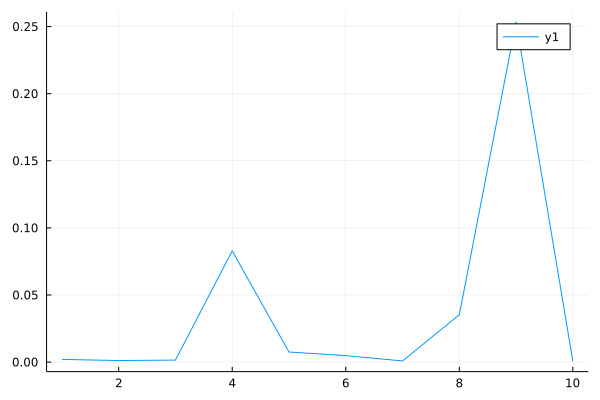

In [43]:
net_param = [5, 50, 100]
G = create_network(net_param)
    
z = randn(5)

stepsize = 1
max_iter = 5000

W = normalized_weight_product(G)
m_list = 100:1000:10000

recov_error = []
for m in m_list

    m = 10000; A = randn(m, 100)/sqrt(m)
    y = sign.(A*G(z))
    z_est = randn(5)

    for i in 1:max_iter
        z_est = PLUGIN_1bitCS_iterate(A, G, W, y, z_est, stepsize)
    end

    push!(recov_error, norm(z/norm(z) - z_est/norm(z_est)))
end
plot(recov_error)


In [4]:
       

G = Chain(
    Dense(5, 75, relu, bias = false; initW =(out,in) ->  randn(75, 5)/sqrt(75)),
    Dense(75, 100, relu, bias = false; initW =(out,in) -> randn(75, 75)/sqrt(75)),
    Dense(75, 150, relu, bias = false; initW =(out,in) -> randn(150, 75)/sqrt(150))
)


z = randn(5)
m = 10000; A = randn(m, 150)/sqrt(m)
y = sign.(A*G(z)) + 1e-14 * randn(m)

stepsize = 1
tolerance = 1e-14
max_iter = 10000
out_toggle = 1000
lambda = 100
z_rec = PLUGIn_onebitCS(G,y,A, max_iter, stepsize, tolerance, lambda, out_toggle)
recov_error = norm(z/norm(z) - z_rec/norm(z_rec))
recon_error = norm(G(z) - G(z_rec))
println("recovery error: $recov_error, reconstruction error: $recon_error")

====> In quasi-gradient: Iteration: 1000 Successive error: 0.04955781631789774
====> In quasi-gradient: Iteration: 2000 Successive error: 0.10578377106837247
====> In quasi-gradient: Iteration: 3000 Successive error: 0.179273944458588
====> In quasi-gradient: Iteration: 4000 Successive error: 0.0978842833014582
====> In quasi-gradient: Iteration: 5000 Successive error: 0.09073658913575064
====> In quasi-gradient: Iteration: 6000 Successive error: 0.18762423367142522
====> In quasi-gradient: Iteration: 7000 Successive error: 0.14405084162435544
====> In quasi-gradient: Iteration: 8000 Successive error: 0.29345628502536225
====> In quasi-gradient: Iteration: 9000 Successive error: 0.14090214879915675
====> In quasi-gradient: Iteration: 10000 Successive error: 0.19772574576799729
====> In quasi-gradient: Iteration: 10001 Successive error: 0.19772574576799729
recovery error: 0.019457811876944658, reconstruction error: 0.5316056983400247


In [19]:

G = Dense(5, 75, relu, bias = false; initW =(out,in) ->  randn(75, 5)/sqrt(75))
G = Chain(G)
G2 = Dense(75, 75, relu, bias = false; initW =(out,in) ->  randn(75, 75)/sqrt(75))

G2 = Chain(G,G2)

G2(randn(5))

75-element Vector{Float64}:
 0.06424112093451002
 0.16878344885888327
 0.0
 0.03876436509600022
 0.14809107093039625
 0.19732114775678872
 0.2787184666914869
 0.17201826110481755
 0.0
 0.006473245880808026
 0.21977642442566125
 0.2823436904598369
 0.0
 ⋮
 0.09118656564201674
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.05515709700285547
 0.13719326332082812
 0.0
 0.0157081181463716
 0.13010968771439982

In [ ]:
#using Zygote to solve ERM for a synthetic problem


G = Chain(
    Dense(5, 75, relu, bias = false; initW =(out,in) ->  randn(75, 5)/sqrt(75)),
    Dense(75, 75, relu, bias = false; initW =(out,in) -> randn(75, 75)/sqrt(75)),
    Dense(75, 150, relu, bias = false; initW =(out,in) -> randn(150, 75)/sqrt(150))
)


z = randn(5)
m = 5000; A = randn(m, 150)/sqrt(m)
y = sign.(A*G(z)) + 1e-14 * randn(m)

stepsize = .1
tolerance = 1e-7
max_iter = 1000
out_toggle = 1000
lambda = 10

z_rec = randn(5)


for i in 1:max_iter

    d = gradient(z_rec -> norm(G(z_rec),2)^2 - 2*lambda * y'*(A * G(z_rec))/m, z_rec)[1]
    z_rec -= stepsize * d
    succ_error = norm(stepsize * d)
    if i % out_toggle == 0  
        println("====> In quasi-gradient: Iteration: $i Successive error: $succ_error")
    end
end


# z_rec = PLUGIn_onebitCS(G,y,A, max_iter, stepsize, tolerance, out_toggle)
recov_error = norm(z/norm(z) - z_rec/norm(z_rec))
recon_error = norm(G(z) - G(z_rec))
println("recovery error: $recov_error, reconstruction error: $recon_error")

====> In quasi-gradient: Iteration: 1000 Successive error: 5.186242623879012e-5
recovery error: 0.05487163727428996, reconstruction error: 0.22544613623562687
